##### Interpretability

This file contains exploration for the part of our datastory concering mapping out the precise differences in lexicon between groups of beers. The philosophy centres on the idea that to be a beer 'connoisseur', you need to use the words that are attirbuted to particular beer characteristics. We first look at the overall lexicon, but this only provides a guide for all beers. To provide beer-specific vocabulary, we look at a group of beers, say IPA, and look at the words used to describe these beers versus other kinds of beers. The biggest (relevant) differences can be interpreted as the words which should be used to describe that group.

We first look at the lexicon for all beers.

In [1]:
import sys
sys.path.append('../')

# Enable continuous module reloading
%load_ext autoreload
%autoreload 1
%aimport src
%aimport src.extractors

# Standard library
import os
import math

# External library
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import spacy
from sklearn.svm import SVC

# NLP library
nlp = spacy.load("en_core_web_sm")

# Seaborn config
sns.set_style("darkgrid")
sns.set_palette("dark")

# Custom modules
from src import utils
from src import extractors
from src import embedders

In [2]:
# Paths
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, "data")
print(DATA_DIR)

# Random seed
SEED = 42

# Subsetting options
SUBSET = False
NUM_SUBSET_SAMPLES = 1_000

/Users/pierrelardet/Documents/University_Academics/Year_3/ADA/ada-2023-project-blackada/data


In [ ]:
# Load all reviews and a subset of reviews (100,000)
if SUBSET:
    reviews = utils.load_data(DATA_DIR, num_samples=NUM_SUBSET_SAMPLES, seed=SEED)
else:
    reviews = utils.load_data(DATA_DIR, seed=SEED)

msg = "Subset of Data" if SUBSET else "Full Data"
print(f"Loaded {len(reviews)} reviews ✅. ({msg})")

In [74]:
processed_reviews = [nlp(text) for text in tqdm(reviews.review.text.tolist())]
reviews[("review", "docs")] = processed_reviews

100%|██████████| 1000/1000 [00:35<00:00, 27.91it/s]


In [162]:
print(reviews[("review", "text")][100])

Clear, dark amber with a fluffy tan head that leaves some decent lace on the glass. Sweet caramel malt and marshmallow with a touch of wintergreen in the aroma. Rich biscuity malt flavors and not much else going on here. It seems that this beer is geared towards macro drinkers who might want something slightly more flavorful than BMC. This beer is along the lines of Killian's or Honey Brown (fitting since it is actually brewed by High Falls!). Light bodied with bright carbonation. A pretty boring beer IMO.


In [147]:
adjective_extractor = extractors.AdjectiveExtractor()
stopword_extractor = extractors.StopwordExtractor()
embedder = embedders.TfidfEmbedder()

# reviews[('review', 'adjectives')] = adjective_extractor.transform(reviews[('review', 'docs')])
# reviews[('review', 'embedding')] = embedder.transform(reviews[('review', 'adjectives')]).tolist()

# Use only stopword removal
reviews[('review', 'no_stopwords')] = stopword_extractor.transform(reviews[('review', 'docs')], lemmatize=True)
print(reviews[('review', 'no_stopwords')].head())
reviews[('review', 'embedding')] = embedder.transform(reviews[('review', 'no_stopwords')]).tolist()

0    , piss yellow fizzy white .   carbonate simila...
1    pale copper thin quickly . Caramel , golden sy...
2    500ml Bottle buy Vintage , Antrim ... golden y...
3    serve : 500ml brown bottlepour : good excellen...
4    500ml bottlepour light , slightly hazy golden ...
Name: (review, no_stopwords), dtype: object


In [3]:
embeddings = np.load(os.path.join(DATA_DIR, "stopword_embeddings.npz"))

In [13]:
embeddings = embeddings['data']

['indices', 'indptr', 'format', 'shape', 'data']


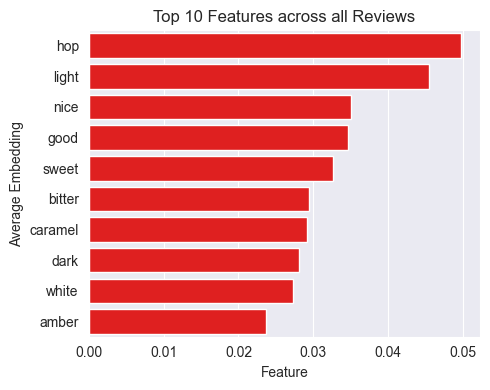

,embedding
hop,0.049750
light,0.045396
nice,0.035071
good,0.034632
sweet,0.032585
...,...
moderate,0.010326
biscuit,0.010291
retention,0.010192
appearance,0.010152


In [157]:
average_embedding = np.array(reviews[('review', 'embedding')].tolist()).mean(axis=0)

top_k = 10
top_k_embeddings = np.argsort(average_embedding)[::-1][:top_k]
top_k_features = np.array(embedder.get_feature_names())[top_k_embeddings]

fig, ax = plt.subplots(figsize=(5, 4))

sns.barplot(y=top_k_features, x=average_embedding[top_k_embeddings], ax=ax, orient="h", color="r")
ax.set_title(f"Top {top_k} Features across all Reviews")
ax.set_xlabel("Feature")
ax.set_ylabel("Average Embedding")
plt.tight_layout()
plt.savefig("./figures/top_overall_features.png", dpi=300)
plt.show()

average_embedding_df = pd.DataFrame(average_embedding, index=embedder.get_feature_names(), columns=["embedding"])
average_embedding_df.sort_values("embedding", ascending=False, inplace=True)
average_embedding_df.head(100)





We now look at differences in vocabular when reviewing a particular beer.

To do this, we first look at the TFIDF average embbedding of a particular subgroup and compare them with the average embedding of the entire group (minus the subgroup). We look at maximum differences between these two sets of embeddings.

We then use an SVM to train a classifier on these differences, which takes into account the distributions rather than just looking at the averages. We can then find the largest coefficients of this model and use these as the most important features to discern between the two groups.

Found 50 unique styles
Found 6 reviews for Euro Pale Lager
Found 191 reviews for English Pale Ale
Found 249 reviews for English Bitter
Found 6 reviews for American Pale Wheat Ale
Found 106 reviews for Irish Red Ale
Found 10 reviews for American Stout


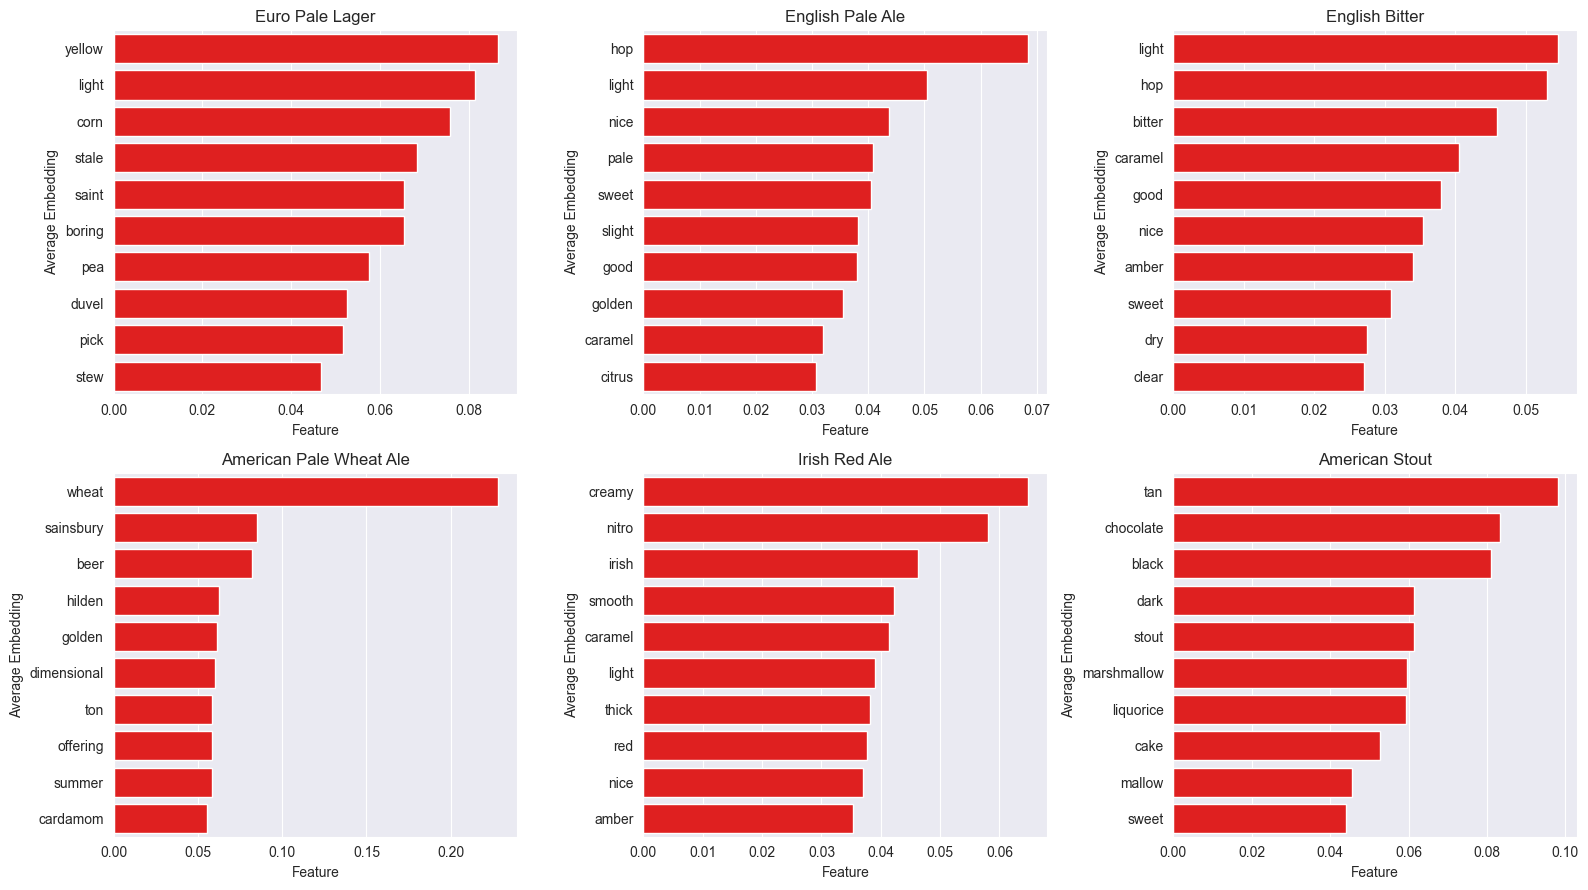

In [155]:
styles = reviews[('beer', 'style')].unique()
print(f"Found {len(styles)} unique styles")
n_styles = 6

# Plot the top 10 features for each style
rows = math.ceil(n_styles / 3)
cols = 3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * rows, 3 * cols))

for i, style in enumerate(styles[:n_styles]):
    style_reviews = reviews[reviews[('beer', 'style')] == style]
    print(f"Found {len(style_reviews)} reviews for {style}")
    style_embedding = np.array(style_reviews[('review', 'embedding')].tolist()).mean(axis=0)
    top_k_embeddings = np.argsort(style_embedding)[::-1][:top_k]
    top_k_features = np.array(embedder.get_feature_names())[top_k_embeddings]
    ax = axes[i //3, i%3]
    sns.barplot(y=top_k_features, x=style_embedding[top_k_embeddings], ax=ax, orient="h", color="r")
    ax.set_title(f"{style}")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Average Embedding")

plt.tight_layout()
plt.savefig('./figures/top_features_by_style.png', dpi=300)
plt.show()


We can now look at a specific subgroup - say English Bitters.

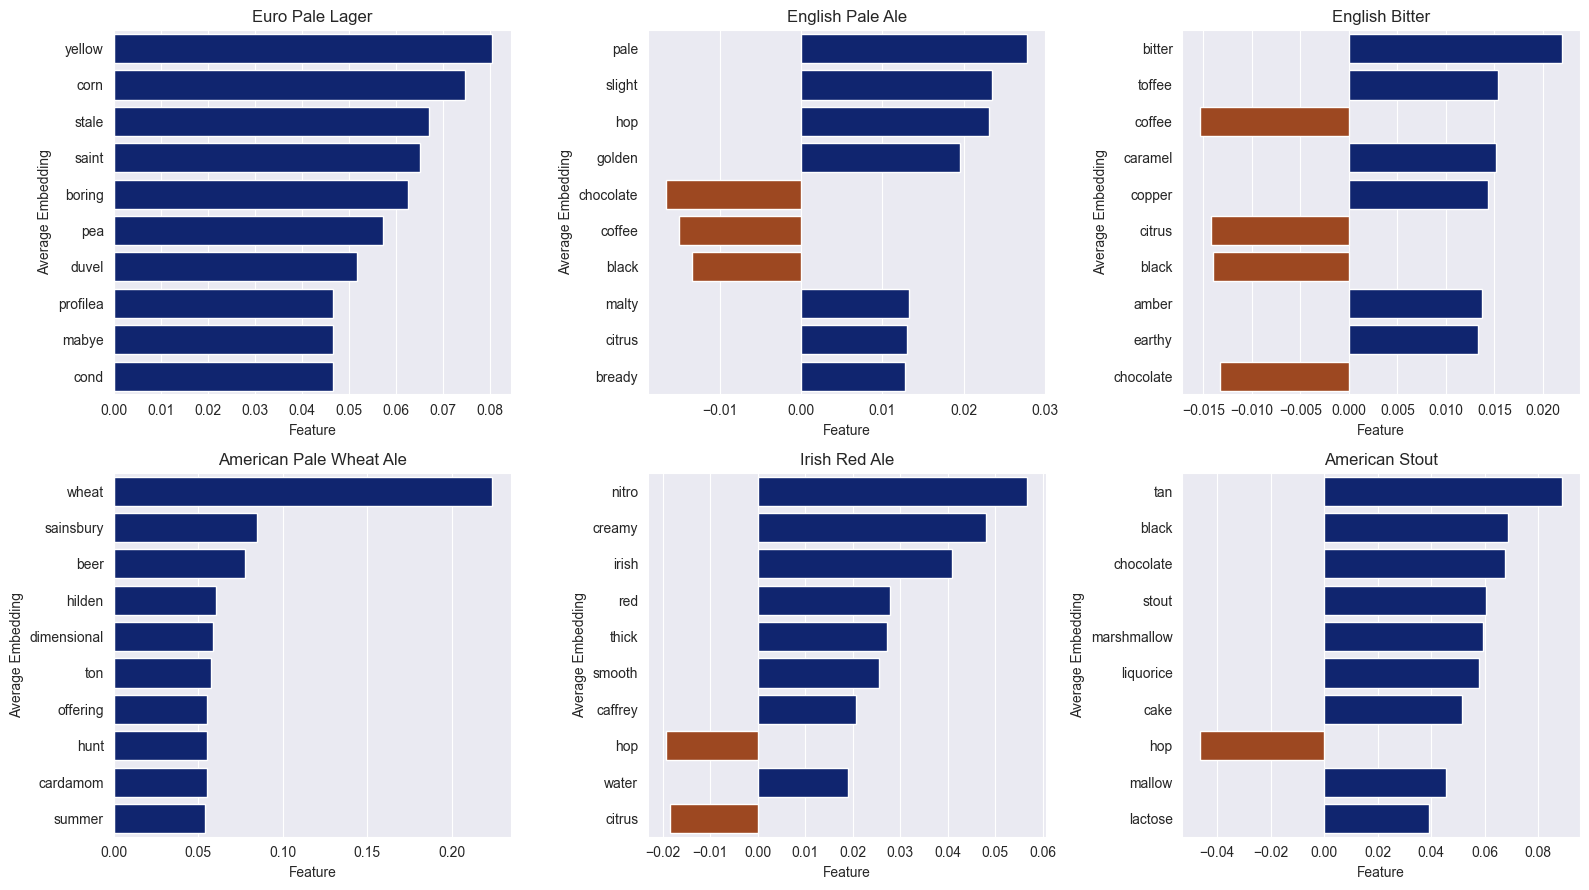

In [156]:
# Plot the top 10 features for each style
rows = math.ceil(n_styles / 3)
cols = 3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * rows, 3 * cols))

for i, style in enumerate(styles[:n_styles]):
    style_reviews = reviews[reviews[('beer', 'style')] == style]
    rest_reviews = reviews[reviews[('beer', 'style')] != style]

    style_embedding = np.array(style_reviews[('review', 'embedding')].tolist()).mean(axis=0)
    rest_embedding = np.array(rest_reviews[('review', 'embedding')].tolist()).mean(axis=0)

    # Take the difference between the style embedding and the rest embedding
    style_diff = style_embedding - rest_embedding

    # Get the top 10 features for the absolute difference
    top_k_embeddings = np.argsort(np.abs(style_diff))[::-1][:top_k]
    top_k_features = np.array(embedder.get_feature_names())[top_k_embeddings]

    # Plot the top 10 differences in features for the style
    colors = ["red" if style_diff[i] > 0 else "blue" for i in top_k_embeddings]

    ax = axes[i // 3, i % 3]

    sns.barplot(y=top_k_features, x=style_diff[top_k_embeddings], ax=ax, orient="h", hue=colors)
    ax.set_title(f"{style}")
    ax.set_xlabel("Feature")
    ax.set_ylabel("Average Embedding")
    ax.get_legend().remove()

plt.tight_layout()
plt.savefig('./figures/top_features_by_style_diff.png', dpi=300)
plt.show()



In [98]:
# Train an SVM to classify into the style or not

style = "English Bitter"

style_reviews = reviews[reviews[('beer', 'style')] == style]
rest_reviews = reviews[reviews[('beer', 'style')] != style]

# Create the data
style_embeddings = np.array(style_reviews[('review', 'embedding')].tolist())
rest_embeddings = np.array(rest_reviews[('review', 'embedding')].tolist())

X = np.concatenate([style_embeddings, rest_embeddings])
y = np.concatenate([np.ones(len(style_embeddings)), np.zeros(len(rest_embeddings))])

# Split the data into train and test
train_size = 0.8
train_idx = int(len(X) * train_size)
X_train, X_test = X[:train_idx], X[train_idx:]
y_train, y_test = y[:train_idx], y[train_idx:]

# Train the SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Evaluate the SVM
print(f"Train Accuracy: {svm.score(X_train, y_train)}")
print(f"Test Accuracy: {svm.score(X_test, y_test)}")

Train Accuracy: 0.96375
Test Accuracy: 0.905


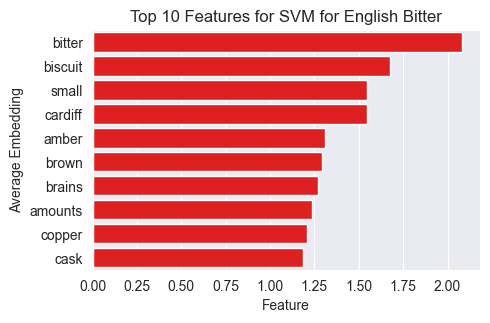

In [112]:
top_k = 10
# Get the top 10 features for the SVM
svm_weights = svm.coef_[0]
top_k_embeddings = np.argsort(svm_weights)[::-1][:top_k]
top_k_features = np.array(embedder.get_feature_names())[top_k_embeddings]

# Plot the top 10 features for the SVM
fig, ax = plt.subplots(figsize=(5, top_k / 3))

sns.barplot(y=top_k_features, x=svm_weights[top_k_embeddings], ax=ax, orient="h", color="r")
ax.set_title(f"Top {top_k} Features for SVM for {style}")
ax.set_xlabel("Feature")
ax.set_ylabel("Average Embedding")
plt.tight_layout()
plt.show()